In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as ds
from torchvision import models, transforms, utils, datasets
from torch.utils import data
from torchsummary import summary
from torch.optim import lr_scheduler

#torch.set_num_threads (8)

In [2]:
torch.manual_seed(13)

In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Data Read-In

In [4]:
batch_size = 64
epoch_samples = 2560# len(samples_weight)

In [5]:
# We normalize to imagenet mean for the data (https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

data_dir = 'data/is_fish_images/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

weighted_samplers = {}
for subset in ["train", "val", "test"]:
    target = image_datasets[subset].targets
    class_sample_count =np.array([ len(np.where(target == t)[0]) for t in np.unique(target)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    epoch_samples = len(samples_weight)

    sampler = data.WeightedRandomSampler(samples_weight, epoch_samples)
    weighted_samplers[subset] = sampler
    


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], sampler = weighted_samplers[x], 
                                              batch_size=batch_size, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

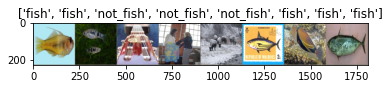

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = utils.make_grid(inputs[0:8])

imshow(out, title=[class_names[x] for x in classes[0:8]])

# Build Model

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
#exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor = .2, patience = 3)

# Train Model

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
def test_model(model, criterion, phase = "test"):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]

    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            print(outputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [11]:
try:
    model_ft.load_state_dict(torch.load("models/is_fish.pt"))
    test_model(model_ft, criterion)
    
except:
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=48)
    torch.save(model_ft.state_dict(), "models/is_fish.pt")


test Loss: 0.0782 Acc: 0.9768


tensor([[ 1.3451, -2.0993],
        [-6.0001,  5.1132],
        [-4.0980,  3.9573],
        [-2.1994,  1.7233],
        [ 1.9375, -2.8772],
        [-1.5463,  0.5494],
        [-6.0644,  5.6013],
        [ 2.1266, -2.7252],
        [ 5.4432, -5.9444],
        [-6.1581,  5.4256],
        [-0.9456, -0.4915],
        [-5.0777,  3.4596],
        [ 2.6905, -4.3196],
        [-5.3703,  4.1172],
        [ 1.7026, -3.1991],
        [ 6.7933, -8.0551],
        [ 1.7232, -3.4618],
        [-5.6352,  3.6765],
        [-2.9542,  1.3656],
        [ 2.6966, -3.9186],
        [-7.1625,  6.2138],
        [ 3.0126, -5.0311],
        [ 2.0942, -2.5434],
        [ 3.7489, -5.4986],
        [-4.3151,  2.6940],
        [-4.6444,  5.0230],
        [-7.1690,  4.8903],
        [ 3.3739, -5.1619],
        [ 0.5240, -1.4718],
        [-4.7095,  2.8511],
        [ 4.0889, -5.1746],
        [-2.9763,  1.2965],
        [-8.5003,  5.5491],
        [-5.4964,  3.3715],
        [-5.2907,  4.3092],
        [ 4.2865, -4

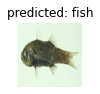

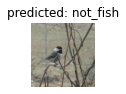

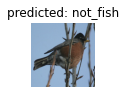

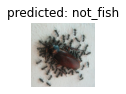

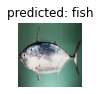

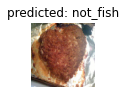

In [12]:
visualize_model(model_ft)

# References
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264